In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [14]:
def load_data(file_path):
    data = pd.read_csv(file_path, names=['x1', 'x2', 'y'])
    data = data.to_numpy()
    X = data[:, 0 : data.shape[1] - 1]
    y = data[:, data.shape[1] - 1]
    return X, y

def compute_priors(y, labels):
    priors = np.zeros(labels.size)
    for i, label in enumerate(labels):
        priors[i] = y[y == label].size / y.size
    return priors

def compute_means(X, y, labels):
    means = np.zeros((labels.size, X.shape[1]))
    for i, label in enumerate(labels):
        means[i] = np.mean(X[y == label], axis=0)
    return means

def compute_sigma(X, y, means, classes):
    X_demean_cls = np.copy(X)
    for i, label in enumerate(classes):
        X_demean_cls[y == label] -= means[i]
    sigma = np.cov(X_demean_cls.T)

    return sigma

def compute_probability(X, sigma, prior, mean):
    x_demeam = X - mean
    xmu_covariance = (x_demeam.dot(np.linalg.pinv(sigma))) * x_demeam
    xmu_covariance_sum = xmu_covariance.sum(axis = 1)
    return -(1/2) * xmu_covariance_sum + np.log(prior)

def compute_probabilities(X, sigma, priors, means, classes):
    probabilities = np.zeros((X.shape[0], priors.size))
    for i in range(len(classes)):
        probabilities[:, i] = compute_probability(X, sigma, priors[i], means[i])
    return probabilities

def get_confusion_matrix(estimates, test_labels, priors):
    num_confusion_matrix = [[0 for x in range(len(priors))] for x in range(len(priors))]
    for i, value in enumerate(estimates): 
        row = int(test_labels[i])
        column = int(value)
        num_confusion_matrix[row][column] += 1
    
    num_confusion_matrix = np.array(num_confusion_matrix)
    return num_confusion_matrix

def predict(probabilities):
    return np.argmax(probabilities, axis=1)

In [15]:
def cal_accuracy(confusion_matrix, total_labels):
    true_sum = np.sum(np.diag(confusion_matrix))
    
    accuracy = true_sum / total_labels 
    return accuracy

def cal_precisions(confusion_matrix):
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)

def cal_recalls(confusion_matrix):
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)

def cal_f1_scores(recalls, percisions):
    return 2 * ((recalls * percisions) / (recalls + percisions))

def report_results(confusion_matrix, total_labels, labels_no, title):
    print('-'*20 + ' ' + title + ' '+ '-'*20)
    recalls = cal_recalls(confusion_matrix).flatten()
    percisions = cal_precisions(confusion_matrix).flatten()
    f1_scores = cal_f1_scores(recalls, percisions).flatten()
    print ("{:<8} {:<15} {:<15} {:<15}".format('Class', 'Recall', 'Precision', 'F1 Scores'))
    for i in range(labels_no):
        print ("{:<8} {:<15} {:<15} {:<15}".format(str(i),\
            str(round((recalls[i] * 100), 2)), round((percisions[i] * 100), 2), round((f1_scores[i] * 100), 2)))
    print("Accuracy: ",  round((cal_accuracy(confusion_matrix, total_labels) * 100), 2), "%")
    print('-'*64)

In [16]:
def plot_3D_pdfs(data, mus, sigma, labels, priors, y_train, title):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))

    colors = ['viridis', 'cividis']
    for label in range(len(labels)):
        X_by_class = data[(y_train == label).flatten()]
        X, Y = np.mgrid[
            np.min(X_by_class[:, 0]):np.max(X_by_class[:, 0]):.01, 
            np.min(X_by_class[:, 1]):np.max(X_by_class[:, 1]):.01
        ]
        pos = np.dstack((X, Y))

        Z = multivariate_normal(mus[label], sigma).pdf(pos)
        ax.plot_surface(X, Y, Z, cmap=colors[label], linewidth=0.2, alpha=0.9, shade=True)
    plt.title(title)
    plt.show()

def plot_dec_boundary_line(ax, X, mus, sigma, priors):
    sigma_inv = np.linalg.pinv(sigma)
    x = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 40).flatten().T
    b0 = 0.5 * mus[0].T.dot(sigma_inv).dot(mus[0])
    b1 = -0.5 * mus[1].T.dot(sigma_inv).dot(mus[1])
    b = b0 + b1 + np.log(priors[0]/priors[1])
    a = sigma_inv.dot(mus[1] - mus[0])
    y = -(b + a[0]*x) / a[1]
    ax.plot(x, y)

def plot_contour(X_data, mus, sigma, labels, priors, y_train, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    for label in range(len(labels)):
        # mu = np.array(mus[label]).flatten()
        # x = np.linspace(mu[0] - 3 * sigma[label][0, 0], mu[0] + 3 * sigma[label][0, 0]).flatten()
        # y = np.linspace(mu[1] - 3 * sigma[label][1, 1], mu[1] + 3 * sigma[label][1, 1]).flatten()

        # X1, Y1 = np.meshgrid(x, y)
        # pos = np.empty(X1.shape + (2,))
        # pos[:, :, 0] = X1
        # pos[:, :, 1] = Y1
        
        X_by_class = X_data[(y_train == label).flatten()]
        X, Y = np.mgrid[
            np.min(X_by_class[:, 0]):np.max(X_by_class[:, 0]):.01, 
            np.min(X_by_class[:, 1]):np.max(X_by_class[:, 1]):.01
        ]
        pos = np.dstack((X, Y))

        Z = multivariate_normal(mus[label], sigma).pdf(pos)
        ax.contour(X, Y, Z)
    plot_dec_boundary_line(ax, X_data,  mus, sigma, priors)
    plt.title(title)
    plt.show()

def plot_scatter_data(X, test_x, prediction, y, mus, sigma, priors, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    correct_classifications = []
    missed_classifications = []
    
    for label in range(2):
        correct_classifications.append(X[np.logical_and(prediction == y, y == (label))])
        missed_classifications.append(X[np.logical_and(prediction != y, y == (label))])
        ax.plot(correct_classifications[int(label)][:, 0], correct_classifications[int(label)][:, 1], '.')
        ax.plot(missed_classifications[int(label)][:, 0], missed_classifications[int(label)][:, 1], 'x')

    plot_dec_boundary_line(ax, X,  mus, sigma, priors)
    plt.title(title)
    plt.show()

-------------------- Train data (1) Results --------------------
Class    Recall          Precision       F1 Scores      
0        99.0            99.0            99.0           
1        99.0            99.0            99.0           
Accuracy:  99.0 %
----------------------------------------------------------------


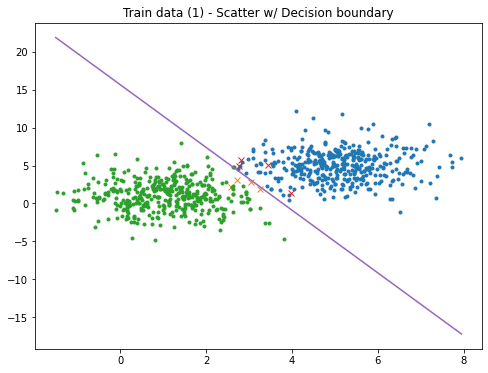

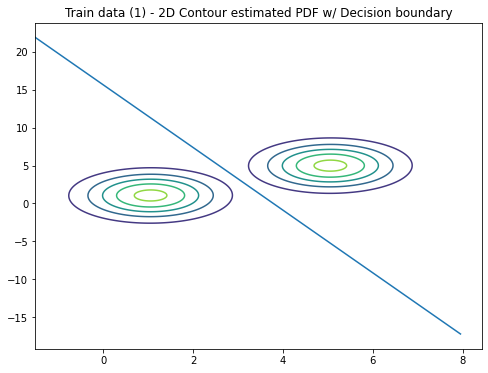

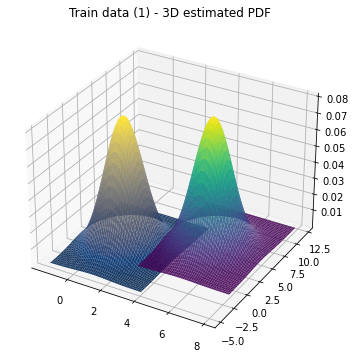

-------------------- Test data (1) Results --------------------
Class    Recall          Precision       F1 Scores      
0        100.0           100.0           100.0          
1        100.0           100.0           100.0          
Accuracy:  100.0 %
----------------------------------------------------------------


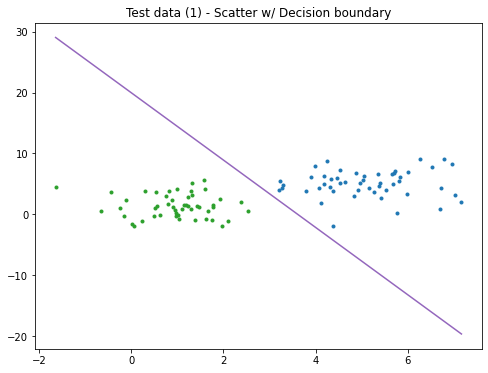

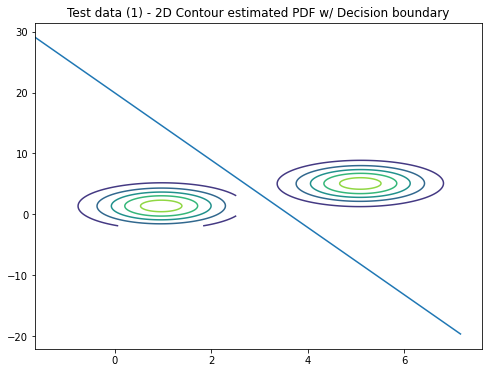

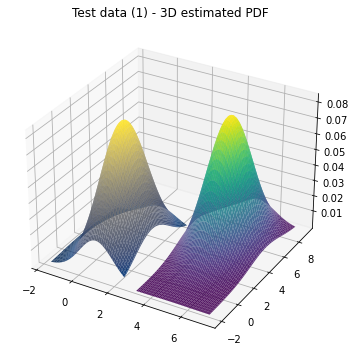

-------------------- Train data (2) Results --------------------
Class    Recall          Precision       F1 Scores      
0        100.0           98.28           99.13          
1        98.25           100.0           99.12          
Accuracy:  99.12 %
----------------------------------------------------------------


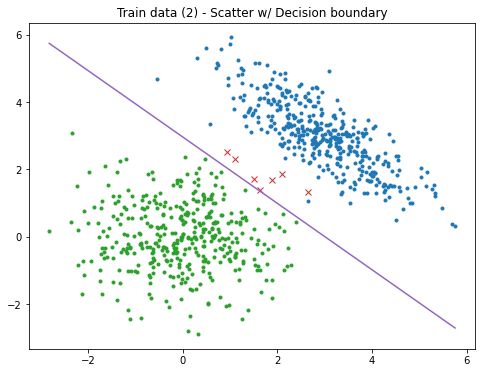

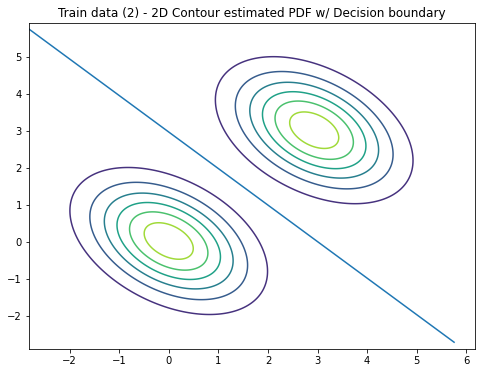

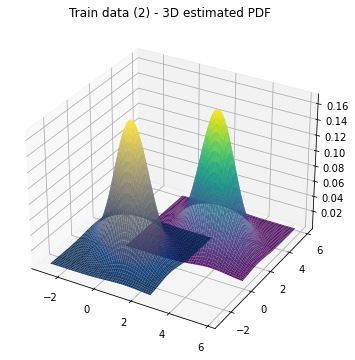

-------------------- Test data (2) Results --------------------
Class    Recall          Precision       F1 Scores      
0        100.0           100.0           100.0          
1        100.0           100.0           100.0          
Accuracy:  100.0 %
----------------------------------------------------------------


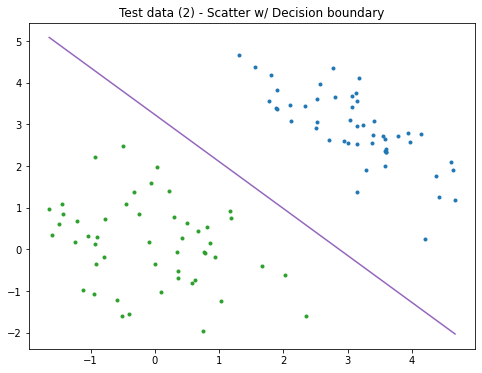

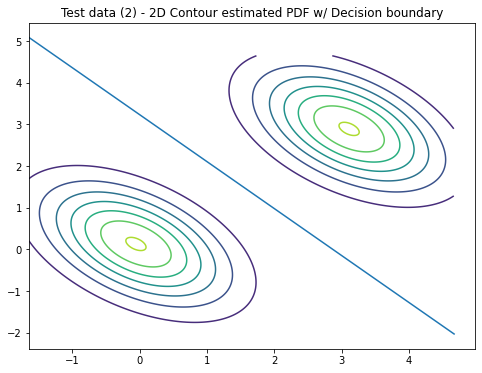

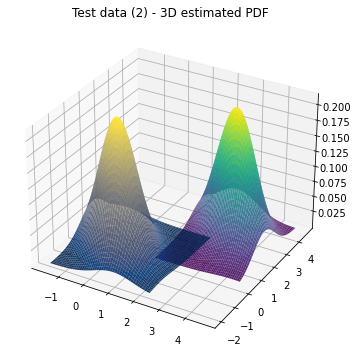

In [17]:
for i in range(2):
    for j in range (2):
        if(j == 0):
            X_train, y_train = load_data(f'BC-Train{i+1}.csv')
            plot_title = f"Train data ({i+1})"
        else:
            X_train, y_train = load_data(f'BC-Test{i+1}.csv')
            plot_title = f"Test data ({i+1})"
        unique_classes, classes_count = np.unique(y_train, return_counts=True)
        unique_classes.sort()
        priors = compute_priors(y_train, unique_classes)
        phi = (classes_count / X_train.shape[0])
        means = compute_means(X_train, y_train, unique_classes)
        sigma = compute_sigma(X_train, y_train, means, unique_classes)
        probs = compute_probabilities(X_train, sigma, priors, means, unique_classes)
        predictions = predict(probs)
        cm = get_confusion_matrix(predictions, y_train, priors)
        report_results(cm, y_train.shape[0], len(classes_count), f'{plot_title} Results')
        plot_scatter_data(X_train, X_train, predictions, y_train, means, sigma, priors, \
            f'{plot_title} - Scatter w/ Decision boundary')  
        plot_contour(X_train, means, sigma, unique_classes, priors, y_train, \
            f'{plot_title} - 2D Contour estimated PDF w/ Decision boundary')
        plot_3D_pdfs(X_train, means, sigma, unique_classes, priors, y_train, \
            f'{plot_title} - 3D estimated PDF')

